<a href="https://colab.research.google.com/github/Abdulkadir2516/spam_filter/blob/main/Spam_Filtresi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls
%cd drive/MyDrive/yapilan_projeler/Spam_Filter/
!ls

drive  sample_data
/content/drive/MyDrive/yapilan_projeler/Spam_Filter
 Dataset  'Spam Filtresi.ipynb'


In [50]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import snowballstemmer as sn
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB




In [ ]:
df = pd.read_excel("Dataset/trspam.xlsx", engine="openpyxl")
df.head()

,0.0,0.0.1,Unnamed: 2
0,Sayın Yetkili ;\n Gelişen ve değişen günümüz ...,spam,NaN
1,"Sayın Yetkili,\n \n28 Kasım 2010 tarihli KPSS ...",spam,NaN
2,Sayın Yetkili ;\n Gelişen ve değişen günümüz ...,spam,NaN
3,T.C.\nURLA KAYMAKAMLIĞI\nURLA HAKAN ÇEKEN ANAD...,spam,NaN
4,Sayın Yetkili ;Hızla büyüyen ve gelişmekte ola...,spam,NaN


In [ ]:
df.rename(columns={'0.0': 'ham_veri', '0.0.1': 'labels'}, inplace=True)
df.drop(['Unnamed: 2'], axis=1, inplace=True)
df.head()



,ham_veri,labels
0,Sayın Yetkili ;\n Gelişen ve değişen günümüz ...,spam
1,"Sayın Yetkili,\n \n28 Kasım 2010 tarihli KPSS ...",spam
2,Sayın Yetkili ;\n Gelişen ve değişen günümüz ...,spam
3,T.C.\nURLA KAYMAKAMLIĞI\nURLA HAKAN ÇEKEN ANAD...,spam
4,Sayın Yetkili ;Hızla büyüyen ve gelişmekte ola...,spam


#Ön işleme

In [17]:
stop_word = "acaba altmış altı ama ancak arada aslında ayrıca az bana bazı belki ben benden beni benim beri beş bile bin bir birçok biri birkaç birkez birşey birşeyi biz bize bizden bizi bizim böyle böylece bu buna bunda bundan bunlar bunları bunların bunu bunun burada çok çünkü da daha dahi de defa değil diğer diye doksan dokuz dolayı dolayısıyla dört edecek eden ederek edilecek ediliyor edilmesi ediyor eğer elli en etmesi etti ettiği ettiğini gibi göre halen hangi hatta hem henüz hep hepsi her herhangi herkesin hiç hiçbir için iki ile ilgili ise işte itibaren itibariyle kadar karşın katrilyon kendi kendilerine kendini kendisi kendisine kendisini kez ki kim kimden kime kimi kimse kırk milyar milyon mu mü mı nasıl ne neden nedenle nerde nerede nereye niye niçin o olan olarak oldu olduğu olduğunu olduklarını olmadı olmadığı olmak olması olmayan olmaz olsa olsun olup olur olursa oluyor on ona ondan onlar onlardan onları onların onu onun otuz oysa öyle pek rağmen sadece sanki sekiz seksen sen senden seni senin siz sizden sizi sizin şey şeyden şeyi şeyler şöyle şu şuna şunda şundan şunları şunu tarafından trilyon tüm üç üzerine var vardı ve veya ya yani yapacak yapılan yapılması yapıyor yapmak yaptı yaptığı yaptığını yaptıkları yedi yerine yetmiş yine yirmi yoksa yüz zaten"
stop_word = stop_word.split()


def stem_word(value):
    stemmer = sn.stemmer("turkish")
    value = value.lower()
    value = stemmer.stemWords(value.split())
    stop_words = stop_word

    value = [item for item in value if not item in stop_words]
    value = ' '.join(value)
    return value

def remove_single_chracter(value):
    return re.sub(r'(?:^| )\w(?:$| )','',value)

#sayılar ve noktalama işaretleri
def numeric_noktalama_remove(metin):
    temiz_metin = re.sub(r'[^\w\s]', '', metin)
    temiz_metin = re.sub(r'\d+', '', temiz_metin)
    return temiz_metin

def remove_link(value):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',value)

def remove_emoji(value):
    bfr = re.compile("[\U00010000-\U0010ffff]",flags=re.UNICODE)
    bfr = bfr.sub(r'',value)
    return bfr

In [18]:
df.ham_veri = df.ham_veri.astype(str).apply(numeric_noktalama_remove)
df.ham_veri = df.ham_veri.apply(stem_word)
df.ham_veri = df.ham_veri.apply(remove_single_chracter)
df.ham_veri = df.ham_veri.apply(remove_link)
df.ham_veri = df.ham_veri.apply(remove_emoji)
df.head()

,ham_veri,labels
0,say yetkil geliş değiş gün teknolojis çalışma ...,spam
1,say yetkil kas tarihli kpss sınav sonuç il yap...,spam
2,say yetkil geliş değiş gün teknolojis çalışma ...,spam
3,tc ur kaymakamlik ur hak çek anadol lises müdü...,spam
4,say yetkil hız büyü gelişmek ol topl büysağlay...,spam


In [19]:
df.ham_veri[0]

'say yetkil geliş değiş gün teknolojis çalışma koşıl özellik kur çalış personel kur bünye çalışma koşul ihtiyaç sağlayabil çalış departma hızlı şekilsağla motiv olabil başka departma geç za oryantasyo adaptasyo süreç başar atlatanyük ver sağla personel ara yadsınamaz gerçek koşul çerçev büro yönet sekreterlik mez al eğit netiç santral memurluk gel evrak gi evrak kayıt sistematik memur sekreterlik eğit al öncelik deva etmes gerekir arşiv yönte kullanılmas büro kullanıl fotokopifaxvp ofis cihaz kullanılmas parmak klavye kulla temel bilgisayar eğit offiç progra kullanılmas temel iktisat istatis kavra yönetiç asistanlık santral operatörlük eğit alarak başar mez ol kiş kur ihtiyacıo personel seç yönetiç asistanlık santral memurluk vhki bilgisayar işletmenlik büro memur pozisyo tercih mezuniyet branşı büro yönet sekreterlik olmas hal kur ihtiyaç karşıla adaptasyo oryantasyo süreç enkıs sür aşacak yük ver alacak kiş rica talep değerlendirme büro yönet sekreterlik mez memn saygı'

In [26]:
df = df.dropna()
df.tail()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ham_veri  825 non-null    object
 1   labels    825 non-null    object
dtypes: object(2)
memory usage: 19.3+ KB


In [28]:
df.groupby("labels").size()

,0
labels,
ham,496
spam,329


In [30]:
msg_train, msg_test, label_train, label_test = train_test_split(df.ham_veri.tolist(), df["labels"].tolist(), test_size=0.2, random_state=42)

In [34]:
len(msg_train),len(msg_test),len(label_train),len(label_test)

(660, 165, 660, 165)

svm accuracy score: 0.9575757575757575
svm accuracy score: 0.9570858817942594


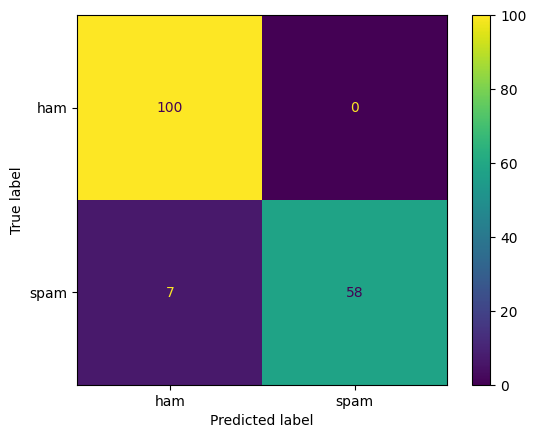

In [47]:
msg_train, msg_test, label_train, label_test = train_test_split(df.ham_veri.tolist(), df["labels"].tolist(), test_size=0.2, random_state=42)
svm = Pipeline([("vect",TfidfVectorizer()),('svm',LinearSVC())])

svm.fit(msg_train,label_train)
y_pred_class = svm.predict(msg_test)

print("svm accuracy score:", accuracy_score(label_test,y_pred_class))
print("svm accuracy score:", f1_score(label_test,y_pred_class,average="weighted"))

cm = confusion_matrix(label_test,y_pred_class, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()

knn accuracy score: 0.9272727272727272
knn accuracy score: 0.9272727272727272


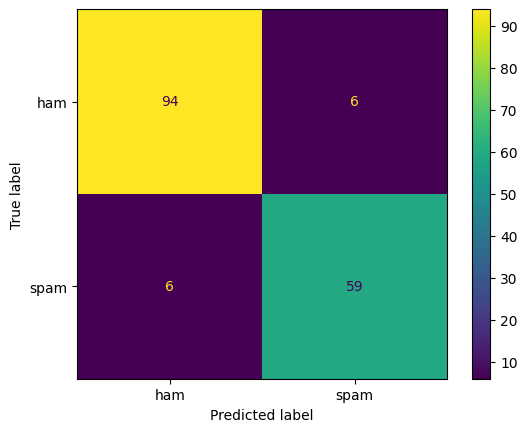

In [51]:
msg_train, msg_test, label_train, label_test = train_test_split(df.ham_veri.tolist(), df["labels"].tolist(), test_size=0.2, random_state=42)
knn = Pipeline([("vect",TfidfVectorizer()),('knn',KNeighborsClassifier())])
knn.fit(msg_train,label_train)
y_pred_class = knn.predict(msg_test)

print("knn accuracy score:", accuracy_score(label_test,y_pred_class))
print("knn accuracy score:", f1_score(label_test,y_pred_class,average="weighted"))

cm = confusion_matrix(label_test, y_pred_class, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

Naive Bayes accuracy score: 0.9151515151515152
Naive Bayes f1 score: 0.9136363636363637


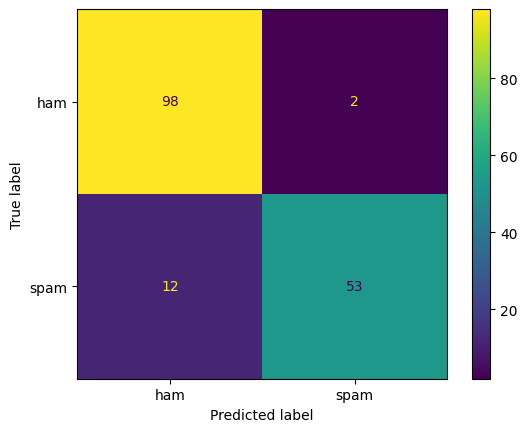

In [52]:
nb = Pipeline([("vect", TfidfVectorizer()), ('nb', MultinomialNB())])
nb.fit(msg_train, label_train)
y_pred_class = nb.predict(msg_test)

print("Naive Bayes accuracy score:", accuracy_score(label_test, y_pred_class))
print("Naive Bayes f1 score:", f1_score(label_test, y_pred_class, average="weighted"))

cm = confusion_matrix(label_test, y_pred_class, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()

In [54]:
# prompt: test etmek istiyorum birilen metinden

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import snowballstemmer as sn
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Example usage of the trained models
test_message = "Windows cihazında Google Hesabınızda yeni bir oturum açma işlemi tespit ettik. Bu işlem size aitse herhangi bir şey yapmanız gerekmez. İşlem size ait değilse hesabınızı güven altına almanıza yardımcı oluruz" # Example spam message
test_message2 = "🔥Anında %20-%30-%40-%50 indirim🔥Her tarza uygun ve birçok renk seçeneğiyle Denim Koleksiyonu'nu yıl sonu fırsatlarıyla keşfet!👇" # Example ham message


# Preprocess the test message using the same functions
test_message = numeric_noktalama_remove(test_message)
test_message = stem_word(test_message)
test_message = remove_single_chracter(test_message)
test_message = remove_link(test_message)
test_message = remove_emoji(test_message)

test_message2 = numeric_noktalama_remove(test_message2)
test_message2 = stem_word(test_message2)
test_message2 = remove_single_chracter(test_message2)
test_message2 = remove_link(test_message2)
test_message2 = remove_emoji(test_message2)

# Make predictions using SVM
svm_prediction = svm.predict([test_message])
print(f"SVM prediction for '{test_message}': {svm_prediction}")

svm_prediction = svm.predict([test_message2])
print(f"SVM prediction for '{test_message2}': {svm_prediction}")

# Make predictions using KNN
knn_prediction = knn.predict([test_message])
print(f"KNN prediction for '{test_message}': {knn_prediction}")

knn_prediction = knn.predict([test_message2])
print(f"KNN prediction for '{test_message2}': {knn_prediction}")

# Make predictions using Naive Bayes
nb_prediction = nb.predict([test_message])
print(f"Naive Bayes prediction for '{test_message}': {nb_prediction}")

nb_prediction = nb.predict([test_message2])
print(f"Naive Bayes prediction for '{test_message2}': {nb_prediction}")

SVM prediction for 'windows cihaz google hesap ye otur açma işle tespit et işle ait yapma gerekmez i̇şle ait hesap güve alt alma yardımcı': ['ham']
SVM prediction for 'an indirimher tarza uygu renk seçenek koleksiyon yıl so fırsat keşfet': ['ham']
KNN prediction for 'windows cihaz google hesap ye otur açma işle tespit et işle ait yapma gerekmez i̇şle ait hesap güve alt alma yardımcı': ['ham']
KNN prediction for 'an indirimher tarza uygu renk seçenek koleksiyon yıl so fırsat keşfet': ['ham']
Naive Bayes prediction for 'windows cihaz google hesap ye otur açma işle tespit et işle ait yapma gerekmez i̇şle ait hesap güve alt alma yardımcı': ['ham']
Naive Bayes prediction for 'an indirimher tarza uygu renk seçenek koleksiyon yıl so fırsat keşfet': ['ham']


In [ ]:
# prompt: bu modelleri kaydedelim başka yerde kullanıcaz

import joblib

# Save the trained models
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(nb, 'nb_model.pkl')

In [ ]:
# prompt: kaydedilen modelleri kullanalım bakalım

# Load the saved models
loaded_svm = joblib.load('svm_model.pkl')
loaded_knn = joblib.load('knn_model.pkl')
loaded_nb = joblib.load('nb_model.pkl')

# Example usage of the loaded models
test_message = "yeni bir mesaj örneği"

# Preprocess the test message (using the same preprocessing steps as before)
test_message = numeric_noktalama_remove(test_message)
test_message = stem_word(test_message)
test_message = remove_single_chracter(test_message)
test_message = remove_link(test_message)
test_message = remove_emoji(test_message)

# Make predictions using the loaded models
svm_prediction = loaded_svm.predict([test_message])
print(f"SVM prediction for '{test_message}': {svm_prediction}")

knn_prediction = loaded_knn.predict([test_message])
print(f"KNN prediction for '{test_message}': {knn_prediction}")

nb_prediction = loaded_nb.predict([test_message])
print(f"Naive Bayes prediction for '{test_message}': {nb_prediction}")